In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
df_predict = pd.read_csv('data/clean_predict.csv')

In [3]:
# wanted to doublecheck if there are missing values
#there are missing values in the columns below, but these columns won't be used as predictors, no need to remove
df_predict.loc[:, df_predict.isna().any()]

,salary_min,salary_max,salary_hourly,salary_yearly
0,21.0,23.0,22.0,NaN
1,100000.0,140000.0,NaN,120000.0
2,25.0,26.0,25.5,NaN
3,NaN,NaN,25.0,NaN
4,73570.0,110350.0,NaN,91960.0
...,...,...,...,...
2224,25.0,35.0,30.0,NaN
2225,16.0,45.0,30.5,NaN
2226,10.0,15.0,12.5,NaN
2227,16.0,45.0,30.5,NaN


In [4]:
#initialy our predictor variables were all the skills, "work_from_home" and "schedule_type"
#from eda I knew that all the skills and "work_from_home" are binary,but "schedule_type is categorical
#wanted to see the distribution of "schedule_type" variable
print(df_predict['schedule_type'].value_counts())


Full-time     1250
Contractor     959
Part-time       19
Internship       1
Name: schedule_type, dtype: int64


In [5]:
#since the "schedule_type" variable needs to be converted into "dummy" varyables(after train_test_split),
#dropped an entry with schedule type "Internship", because there is only one occurence(1) and it would end up in either training set or testing set
df_predict = df_predict.drop(df_predict[df_predict['schedule_type'] == 'Internship'].index)

In [6]:
#remove redundant column, we already created all the separate columns for each skill
del df_predict['description_tokens']

### After having done linear regression with all available skills as it was instructed, linear regression model performed terribly with the following results:
* r2: -1.4040321426491305e+22
* Mean Absolute Error: 414869076695351.3
* RMSE: 4615088934598429.0





### Since the performance metrics are bad I've decided to take some further steps to find the reason behind it
### First, I have decided to transform the data further.


### The graph below shows us that te majority of the skills have an imbalanced distribution, where 0 is most frequent value and 1 is the least frequent. So we can see in the graph below vast majority of skills are present in less than a hundred rows out of total 2229 rows.

### This is a problem, because imbalanced distribution of binary variables can lead to issues such as biased model performance or poor generalization to new data. 

### Another issue present here is a large number of predictor variables(over 200). It increases dimensionality and leads to poor performance of linear regression model. 

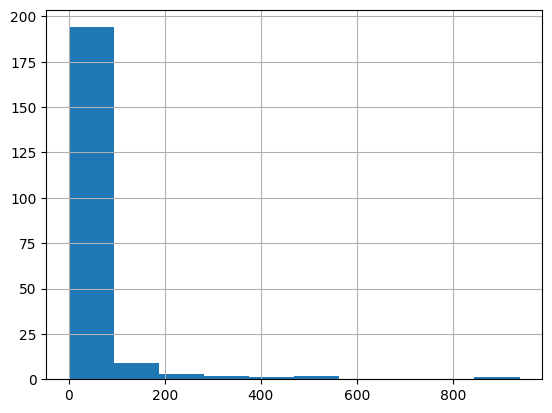

In [7]:
#chose all the columns that contain skills and save their names into list
skills = [col for col in df_predict if col.startswith('desc')]
#use the skills list to select the columns and count sum of 1s in every column
df_predict[skills].sum().sort_values(ascending=False).hist();

### In attempt to fix the issues mentioned above, I took the liberty to remove the skills that occur 100 or less times in the dataframe(values equal to 1)

In [8]:
skills = df_predict[skills]
skills = skills[skills.columns[skills.sum() > 100]]

In [9]:
#split the data into predictor variables and the target variable
#choose predictors from "old" data frame and concat with "new" skills dataframe
X = pd.concat([skills,df_predict[['work_from_home','schedule_type']]],axis=1)
y = df_predict[['salary_standardized']]

In [10]:
#splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

In [11]:
# Since all the data needs to be either numeric or boolean, created dummy variables for our categorical variable 'schedule_type'
#separately for X_train and X_test sets to prevent data leakage
dummies_train = pd.get_dummies(X_train[['schedule_type']])
# Concatenate the dummy variables with the original DataFrame
X_train = pd.concat([X_train, dummies_train], axis=1)
# delete redundant column
del X_train['schedule_type']
dummies_test = pd.get_dummies(X_test[['schedule_type']])
# Concatenate the dummy variables with the original DataFrame
X_test = pd.concat([X_test, dummies_test], axis=1)
# delete redundant column
del X_test['schedule_type']

### Another attempt to build a linear regression model after data transformations mentioned above.

In [12]:
#create a linear regression object
reg = LinearRegression()
#fit the linear regression model to the data
reg.fit(X_train, y_train)
# print the intercept and coefficients of the linear regression model
print("Intercept:", reg.intercept_)
print("Coefficients:", reg.coef_)

# predict the target variable for a new input
y_pred = reg.predict(X_test)
print('r2',r2_score(y_test,y_pred))
print('Mean Absolute Error',mean_absolute_error(y_test,y_pred))
print('RMSE',mean_squared_error(y_test,y_pred,squared=False))

Intercept: [2.99026182e+17]
Coefficients: [[ 7.77936010e+03 -3.26025979e+03 -1.92971292e+03 -8.83385982e+02
   8.71405203e+03  1.33063097e+03  2.64420975e+03  1.01503778e+04
   4.13490600e+03  5.90402269e+02 -2.88657164e+03 -4.47808203e+03
  -4.26625976e+03 -3.69342160e+02  4.78725953e+02  2.15161026e+03
  -4.16860263e+03 -3.46539294e+03 -2.99026182e+17 -2.99026182e+17
  -2.99026182e+17]]
r2 0.00035697773152232326
Mean Absolute Error 28278.755269058292
RMSE 38941.620380587185


### Unfortunately, the model kept performing poorly. I decided to explore futher and to test if the reason for poor performance is the lack of statistically significant relationships between predictor variables and the target variable.
### For binary features, we can use ttest and for categorical feature we can use ANOVA test.
### H0 states that there is no statistically significant relationship between a given predictor variable and the target variable.
### Ha states that there is a statistically significant relationship between a given predictor variable and the target variable.
### For p-values below 0.05 null hypothesis can be rejected.

In [13]:
#perform ttest
#declare a dictionary to collect all the p_values for each predictor
p_values = {}
for i in X.columns:
    group1 = y[X[i] == 0]
    group2 = y[X[i] == 1]
    t_statistic, p_value = ttest_ind(group1, group2)
    p_values[i]=p_value

In [14]:
p_values

{'description_token_ aws': array([0.05387192]),
 'description_token_ excel': array([0.2406961]),
 'description_token_ microstrategy': array([0.70984436]),
 'description_token_ power_bi': array([0.23553657]),
 'description_token_ powerpoint': array([0.19728979]),
 'description_token_ python': array([0.05834929]),
 'description_token_ r': array([0.15616466]),
 'description_token_ sas': array([0.02653915]),
 'description_token_ snowflake': array([0.07533585]),
 'description_token_ sql': array([0.09255576]),
 'description_token_ tableau': array([0.67427093]),
 'description_token_ word': array([0.97772856]),
 'description_token_excel': array([0.14480054]),
 'description_token_jira': array([0.80844175]),
 'description_token_power_bi': array([0.76690206]),
 'description_token_sql': array([0.8931665]),
 'description_token_tableau': array([0.77353738]),
 'work_from_home': array([8.372142e-05]),
 'schedule_type': array([nan])}

### In the EDA we found out that the most sought after skills for 'data analyst' are python, power bi, tableau, sql and excel. However, neither of these skills showed statistically significant relationship with the target variable 'salary_standardized'.

In [15]:
# delete features with p-values below 0.05
significant_features = {k:v for k,v in p_values.items() if v < 0.05}
# the ttest showed that these features have statistically significant relationship with target variable
#in the EDA sas wasn't one of the top skills
print(significant_features)

{'description_token_ sas': array([0.02653915]), 'work_from_home': array([8.372142e-05])}


In [16]:
# Create a formula for the ANOVA test
formula = 'salary_standardized ~ schedule_type'

# Create a linear regression model using the formula
model = ols(formula, data=df_predict).fit()

# Perform an ANOVA test on the model
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print("The p_value for 'schedule_type' feature is:", anova_table['PR(>F)'].schedule_type) 

The p_value for 'schedule_type' feature is: 0.00046446744290355144


### Anova test showed that 'schedule_type' has a statistically significant relationship with target variable.

### While troubleshooting and trying to understand why linear regression performs so badly despite all the data alterations, started looking into the target variable to see if it could influence model's performance.

In [17]:
y.value_counts()

salary_standardized
96500.0                314
119600.0                74
63440.0                 69
103781.0                63
145600.0                60
                      ... 
89440.0                  1
90250.0                  1
90500.0                  1
90906.4                  1
322400.0                 1
Length: 362, dtype: int64

### As you can see above, despite the fact that our target variable is continous, it has a low variance, meaning that it has a lot of repeated values. And I can assume, that this fact could contribute to the poor linear regression performance. 
### As a result of this observation, I've decided to transform continous target variable into categories and build a Logistic Regression model instead.

In [18]:
y['y_category'] = pd.cut(y['salary_standardized'],bins=4)
print(y['y_category'].value_counts())
y = y[['y_category']]

(94640.0, 170560.0]     1217
(18416.32, 94640.0]      914
(170560.0, 246480.0]      85
(246480.0, 322400.0]      12
Name: y_category, dtype: int64


/var/folders/kc/j4ss26096jv9xkwkcr7z36kr0000gn/T/ipykernel_88134/3726501467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_category'] = pd.cut(y['salary_standardized'],bins=4)


In [19]:
#transofrm category labels into integers
mlb = LabelEncoder()
#update y with salary_standardized categories
y = mlb.fit_transform(y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)
# Since all the data needs to be either numeric or boolean, created dummy variables for the categorical variable 'schedule_type'
#separately for X_train and X_test sets to prevent data leakage
dummies_train = pd.get_dummies(X_train[['schedule_type']])
# concatenate the dummy variables with the original X_train df
X_train = pd.concat([X_train, dummies_train], axis=1)
# delete redundant column
del X_train['schedule_type']
dummies_test = pd.get_dummies(X_test[['schedule_type']])
# concatenate the dummy variables with the original X_test df
X_test = pd.concat([X_test, dummies_test], axis=1)
# delete redundant column
del X_test['schedule_type']

In [21]:
# create a logistic regression model for multinomial classification
lr_model = LogisticRegression(C=0.01, penalty='l2', multi_class='multinomial',
                              solver='saga',random_state=50).fit(X_train,y_train)

# fit the model to the training data
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)
# make predictions on the test data
y_pred = lr_model.predict(X_test)
print(f'Logistic Regression\n')
roc = roc_auc_score(y_test, lr_probs,multi_class='ovr')
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, y_pred,zero_division=0))

# evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred)) 
 

Logistic Regression

ROC AUC: 0.7273
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       254
           1       0.71      0.73      0.72       386
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00         3

    accuracy                           0.65       669
   macro avg       0.32      0.33      0.32       669
weighted avg       0.62      0.65      0.63       669

Accuracy: 0.6457399103139013


### We can see that accuracy increased with Logistic Regression significantly. However, with only get 2 categories in our prediction. It's a result of imbalanced target variable. The distribution of data in target variable is skewed towards 2 classes. The model ends up predicting majority classes.

In [22]:
#the model didn't classify two minority classes: 2 and 3
y_pred 

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,

In [23]:
#reverse the labels to the original intervals
original_intervals = mlb.inverse_transform(y_pred)

In [24]:
original_intervals

array([Interval(18416.32, 94640.0, closed='right'),
       Interval(18416.32, 94640.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(18416.32, 94640.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(18416.32, 94640.0, closed='right'),
       Interval(18416.32, 94640.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(18416.32, 94640.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Interval(94640.0, 170560.0, closed='right'),
       Inter